In [1]:
import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
import math

def GAIA_query(ra0,dec0,mag_limit):
    job = Gaia.launch_job_async("SELECT *     FROM gaiadr3.gaia_source     WHERE CONTAINS(POINT(gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE("+str(ra0)+","+str(dec0)+","+str(10/60)+"))=1     AND phot_g_mean_mag IS NOT NULL     AND parallax IS NOT NULL     ORDER BY phot_g_mean_mag ASC;", dump_to_file=False)

    GAIA_data = job.get_results()
    
    ra=[]
    dec=[]
    mag=[]
    
    for i in range(0,len(GAIA_data)):
        if GAIA_data['phot_g_mean_mag'][i]<=mag_limit:
            mag.append(GAIA_data['phot_g_mean_mag'][i])
            ra.append(GAIA_data['ra'][i])
            dec.append(GAIA_data['dec'][i])

    scales=[] #Need scale values for the marker size of each star to illustrate magnitude on a plot

    for i in mag: #Scale is linear with magnitude from {16}, i.e mag {12} star has marker size {2} times larger than a mag {14} star.
        I=(mag_limit-i)
        scales.append(I*10)

    stars_data=pd.DataFrame({'ra':ra,'dec':dec,'mag':mag,'scale':scales}) #naturally sorted by magnitude

    input_data={}
    input_data['mag_limit']=mag_limit
    input_data['source']="query"
    input_data['ra0']=ra0 * u.deg
    input_data['dec0']=dec0 * u.deg

    return stars_data,input_data



Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
data,input_data=GAIA_query(54.1,-27.8,18)

INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

class FOV_stars: #Class for the FOV simulation
    def __init__(self,stars_data,input_data):
        self.stars_data=stars_data.copy() #Pandas DataFrame of the stars' data. Stores ra, dec, mag, and "scale" (for graphical plotting)
        self.input_data=input_data

        self.const={}
        self.const['inner_annulus_D']=7.4 * u.arcsec
        self.const['inner_circle_D']=5 * u.arcsec
        self.const['outer_annulus_D']=10 * u.arcsec
        self.const['LGS_radial_D']=7.4 * u.arcsec
        self.const['LGS_D']=2.2 * u.arcsec 
        self.const['PFS_arm_width']=0.5 * u.arcsec
        self.const['PFS_arm_length']=0.5 * u.arcsec
        self.const['PFS_arm_ang_sep']=45 * u.deg
        self.const['PFS_stars_min_mag']=15.5
        self.const['NGS_stars_min_sep']=1 * u.arcsec
        self.const['NGS_stars_min_mag']=17

        self.stats={}

    def orthographic(self,ra,dec,ra0,dec0): #Orthographic projection plane around ra0 and dec0
        x=np.cos(dec)*np.sin(ra-ra0)
        y=np.cos(dec0)*np.sin(dec)-np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)
        return x,y

    def distance(self,A,B): #Distance between points A and B:
        d=np.sqrt((A[0]-B[0])**2+(A[1]-B[1])**2)
        return d  
    
    def line(self,A,B): #Returns gradient (m) and y intercept (c) of a line joining points A and B, form y=m*x+c
        m=(A[1]-B[1])/(A[0]-B[0])
        c=A[1]-m*A[0] 
        return m,c

    def perp_line(self,m,c,C): #Returns gradient and y intercept of a line perpendicular to y=m*x+c going through C
        m_perp=-1/m
        c_perp=C[1]-m_perp*C[0]
        return m_perp,c_perp   
   
    def convert_stars_to_xy(self,ra0,dec0):
        ra0=ra0.to(u.rad).value
        dec0=dec0.to(u.rad).value

        self.stars_data['x'],self.stars_data['y']=self.orthographic(np.radians(self.stars_data['ra']),np.radians(self.stars_data['dec']),ra0,dec0) #Angles need to be in radians
        void,self.arcmin_in_xy=self.orthographic(ra0,dec0+ np.radians(1/60),ra0,dec0) #Length of 1 arcmin in the x,y projection units: used as a scale for conversion

        self.const['outer_annulus_xyD']=self.const['outer_annulus_D']*self.arcmin_in_xy #Using the 1 arcmin length in x,y, converts the outer annulus diameter to x,y units
        self.const['inner_annulus_xyD']=self.const['inner_annulus_D']*self.arcmin_in_xy #Using the 1 arcmin length in x,y, converts the inner annulus diameter to x,y units
        self.const['inner_circle_xyD']=self.const['inner_circle_D']*self.arcmin_in_xy #Using the 1 arcmin length in x,y, converts the inner circle diameter to x,y units
       
        return
   
    def find_stars_zones(self,x_offset=0,y_offset=0):
        #3 for inner circle, 2 for inner annulus, 1 for outer annulus, 0 for none
        zones=[]
        for i in range(0,len(self.stars_data)):
            dist = self.distance([self.stars_data['x'][i],self.stars_data['y'][i]],[0-x_offset,0-y_offset])
            if dist < self.const['outer_annulus_xyD'].value/2:
                if dist < self.const['inner_annulus_xyD'].value/2:
                    if dist < self.const['inner_circle_xyD'].value/2:
                        zones.append(1)
                    else: 
                        zones.append(2)
                else:
                    zones.append(3)
            else:
                zones.append(4)

        self.stars_data['zone']=zones

        return

    def find_PFS(self):
        PFS_arm_xywidth=self.const['PFS_arm_width'].value*self.arcmin_in_xy #Distance from PFS star to edge of PFS arm widthways in x,y units
        PFS_arm_xylength=self.const['PFS_arm_length'].value*self.arcmin_in_xy #Distance from PFS star to end of PFS arm in x,y units
        
        self.stars_data['label']=""

        #available star = 0, PFS star = "S_PFS", obscured by PFS = "O_PFS", obscured by both LGS and PFS = "O_PFS_LGS", obscured by LGS = "O_LGS", NGS = "S_NGS"
        angles=[]
        PFS_arms = [[],[],[]]    

        for i in self.stars_data.loc[(self.stars_data['zone']==3) | (self.stars_data['zone']==2)].index:
            if self.stars_data['mag'][i]<self.const['PFS_stars_min_mag']:
                theta=math.atan2(self.stars_data['x'][i],self.stars_data['y'][i])
                
                if all(abs(theta - val )  > self.const['PFS_arm_ang_sep'].to(u.rad).value for val in angles):
                    self.stars_data.at[i,'label']="S_PFS"

                    A=(self.stars_data['x'][i]-PFS_arm_xylength*np.sin(theta)+PFS_arm_xywidth*np.cos(theta),
                    self.stars_data['y'][i]-PFS_arm_xylength*np.cos(theta)-PFS_arm_xywidth*np.sin(theta))
                    B=(self.stars_data['x'][i]-PFS_arm_xylength*np.sin(theta)-PFS_arm_xywidth*np.cos(theta),
                    self.stars_data['y'][i]-PFS_arm_xylength*np.cos(theta)+PFS_arm_xywidth*np.sin(theta))

                    AB_m,AB_c=self.line(A,B)
                    AD_m,AD_c=self.perp_line(AB_m,AB_c,A)
                    BC_m,BC_c=self.perp_line(AB_m,AB_c,B)

                    #Following calculates C and D positions, the origins of the PFS arms: they "originate" at the top/bottom of the FOV boundary
                    if np.pi/2>theta>-np.pi/2: #Ifs PFS star in top half, origins are at y=+FOV boundary
                        C=((self.const['outer_annulus_xyD'].value/2-BC_c)/BC_m,self.const['outer_annulus_xyD'].value/2)
                        D=((self.const['outer_annulus_xyD'].value/2-AD_c)/AD_m,self.const['outer_annulus_xyD'].value/2) 
                    else: #If PFS star in bottom half, origins are at y=-FOV boundary
                        C=((-self.const['outer_annulus_xyD'].value/2-BC_c)/BC_m,-self.const['outer_annulus_xyD'].value/2)
                        D=((-self.const['outer_annulus_xyD'].value/2-AD_c)/AD_m,-self.const['outer_annulus_xyD'].value/2)   

                    PFS_arms[len(angles)]=[A,B,C,D,AB_m,AB_c,AD_m,AD_c,BC_m,BC_c,theta]
                    angles.append(theta)               

            if len(angles)==3:
                break

        self.PFS_arms=pd.DataFrame(PFS_arms,columns=['A','B','C','D','AB_m','AB_c','AD_m','AD_c','BC_m','BC_c','theta'])

        for i in self.stars_data.loc[(self.stars_data['label']!="S_PFS")].index:
            starx=self.stars_data['x'][i]
            stary=self.stars_data['y'][i]
            for o, theta in enumerate(angles): #Checks each star against each PFS arm
                AB_m,AB_c=self.PFS_arms['AB_m'][o],self.PFS_arms['AB_c'][o]
                AD_m,AD_c=self.PFS_arms['AD_m'][o],self.PFS_arms['AD_c'][o]
                BC_m,BC_c=self.PFS_arms['BC_m'][o],self.PFS_arms['BC_c'][o]

                #The orientation of the arms sides depends on the star's angle/quadrant, and this alters the inequality conditions for vignetting
                if 0>theta>-np.pi/2 and stary>AB_m*starx+AB_c and stary<AD_m*starx+AD_c and stary>BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
                elif -np.pi/2>theta>-np.pi and stary<AB_m*starx+AB_c and stary<AD_m*starx+AD_c and stary>BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
                elif np.pi>theta>np.pi/2 and stary<AB_m*starx+AB_c and stary>AD_m*starx+AD_c and stary<BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
                elif np.pi/2>theta>0 and stary>AB_m*starx+AB_c and stary>AD_m*starx+AD_c and stary<BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
        
        return 

    def find_LGS(self,LGS_angle):      
        self.const['LGS_xyD']=self.const['LGS_D'].value*self.arcmin_in_xy #Distance of LGS footprints from FOV centre in x,y units
        self.const['LGS_radial_xyD']=self.const['LGS_radial_D'].value*self.arcmin_in_xy #Radius of LGS footprint in x,y units
        
        #Following calculates the x and y positions of the 4 LGS footprints using the LGS angle and LGS distance from FOV centre
        LGS_pos=[[self.const['LGS_radial_xyD']/2*np.sin(LGS_angle),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle)],[self.const['LGS_radial_xyD']/2*np.sin(LGS_angle+np.pi/2),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle+np.pi/2)],
                [self.const['LGS_radial_xyD']/2*np.sin(LGS_angle+np.pi),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle+np.pi)],[self.const['LGS_radial_xyD']/2*np.sin(LGS_angle+3*np.pi/2),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle+3*np.pi/2)]]

        self.const['LGS_pos']=LGS_pos
        #Following takes x,y of each FOV star not vignetted by PFS arms and identifies if they are within the equation of a circle for the LGS footprints
        for i in range(0,len(self.stars_data)):
            for o in range(0,4):
                if (self.stars_data['x'][i]-LGS_pos[o][0])**2+(self.stars_data['y'][i]-LGS_pos[o][1])**2<(self.const['LGS_xyD']/2)**2:
                    self.stars_data.at[i,'label']=self.stars_data.at[i,'label']+"O_LGS"
              
        return

    def find_NGS(self,override=True):
        potential=self.stars_data.loc[((self.stars_data['zone']==1) | (self.stars_data['zone']==2)) & (self.stars_data['label']=="") & (self.stars_data['mag'] < self.const['NGS_stars_min_mag'])].index

        if len(potential) == 0: #Stops function from breaking
            print("No Potential NGS Stars")
            potential=[]
            return

        confirmed=[potential[0]]
        for i in range(1,len(potential)):
            if abs(self.distance([self.stars_data['x'][confirmed[0]]-self.stars_data['x'][potential[i]],self.stars_data['y'][confirmed[0]]-self.stars_data['y'][potential[i]]],[0,0]))>self.const['NGS_stars_min_sep'].value*self.arcmin_in_xy: #SCALE!!!
                confirmed.append(potential[i])
                break

        for o in range(i,len(potential)):
            if (abs(self.distance([self.stars_data['x'][confirmed[0]]-self.stars_data['x'][potential[o]],self.stars_data['y'][confirmed[0]]-self.stars_data['y'][potential[o]]],[0,0]))>self.const['NGS_stars_min_sep'].value*self.arcmin_in_xy
            and abs(self.distance([self.stars_data['x'][confirmed[1]]-self.stars_data['x'][potential[o]],self.stars_data['y'][confirmed[1]]-self.stars_data['y'][potential[o]]],[0,0]))>self.const['NGS_stars_min_sep'].value*self.arcmin_in_xy):
                confirmed.append(potential[o])
                break

        for i in confirmed:
            self.stars_data.at[i,'label']="S_NGS"
        
        return

    def find_NGS_stats(self):
        NGS_stars=self.stars_data.loc[self.stars_data['label']=="S_NGS"].index

        if len(NGS_stars)==3:
            a,b,c=NGS_stars[0],NGS_stars[1],NGS_stars[2]
            self.stats['NGS_area']=((self.stars_data['x'][a]*self.stars_data['y'][b]+self.stars_data['x'][b]*self.stars_data['y'][c]+self.stars_data['x'][c]*self.stars_data['y'][a]
                                -self.stars_data['y'][a]*self.stars_data['x'][b]-self.stars_data['y'][b]*self.stars_data['x'][c]-self.stars_data['y'][c]*self.stars_data['x'][a])/(2*self.arcmin_in_xy**2))
            self.stats['NGS_barycentre']=[(self.stars_data['x'][a]+self.stars_data['x'][b]+self.stars_data['x'][c])/(3*self.arcmin_in_xy),(self.stars_data['y'][a]+self.stars_data['y'][b]+self.stars_data['y'][c])/(3*self.arcmin_in_xy)]  
            self.stats['NGS_barycentre_D']=np.sqrt(self.stats['NGS_barycentre'][0]**2+self.stats['NGS_barycentre'][1]**2)

        if len(NGS_stars)==2:
            a,b=NGS_stars[0],NGS_stars[1]
            self.stats['NGS_barycentre']=[(self.stars_data['x'][a]+self.stars_data['x'][b])/(2*self.arcmin_in_xy),(self.stars_data['y'][a]+self.stars_data['y'][b])/(2*self.arcmin_in_xy)]
            self.stats['NGS_barycentre_D']=np.sqrt(self.stats['NGS_barycentre'][0]**2+self.stats['NGS_barycentre'][1]**2)

        if len(NGS_stars)==1:
            a=NGS_stars[0]
            self.stats['NGS_barycentre']=[self.stars_data['x'][a],self.stars_data['y'][a]]
            self.stats['NGS_barycentre_D']=np.sqrt(self.stats['NGS_barycentre'][0]**2+self.stats['NGS_barycentre'][1]**2)

        return

    def find_PFS_overlap(self):
        PFS_stars=self.stars_data.loc[(self.stars_data['label']=="S_PFS")|(self.stars_data['label']=="S_PFSO_LGS")].index
        LGS_xyR=self.const['LGS_xyD']/2
        intercepts=[[],[],[]]
        intercepts_footprints=[None,None,None]
        overlap_areas=[0,0,0]

        for PFS in range(0,len(PFS_stars)):
            theta=self.PFS_arms['theta'][PFS]
            for LGS in range(0,4):
                p,q=self.const['LGS_pos'][LGS][0],self.const['LGS_pos'][LGS][1]
                for arm in ['AD','AB','BC']:
                    m,c=self.PFS_arms[arm+'_m'][PFS],self.PFS_arms[arm+'_c'][PFS]
                    a,b,c2=1+m**2,2*(m*c-m*q-p),p**2-LGS_xyR**2+c**2+q**2-2*c*q
                    det=b**2-4*a*c2

                    if det > 0:
                        x_vals=[(-b+np.sqrt(det))/(2*a),(-b-np.sqrt(det))/(2*a)]
                        for x_val in x_vals:
                            if arm == 'AD' or arm =='BC':
                                corner = 'A' if arm == 'AD' else 'B'
                                if theta < 0 and x_val < self.PFS_arms[corner][PFS][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS
                                if theta > 0 and x_val > self.PFS_arms[corner][PFS][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS
                            else:
                                if np.pi/2>theta>-np.pi/2 and self.PFS_arms['A'][PFS][0] > x_val > self.PFS_arms['B'][PFS][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS
                                if (theta < -np.pi/2 or theta > np.pi/2) and self.PFS_arms['B'][PFS][0] > x_val > self.PFS_arms['A'][PFS][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS

        for count, intercept in enumerate(intercepts):
            corners_inside=0
            if intercept != []:
                A,B=self.PFS_arms['A'][count],self.PFS_arms['B'][count]
                footprint=intercepts_footprints[count]
                LGS_x,LGS_y=self.const['LGS_pos'][footprint][0],self.const['LGS_pos'][footprint][1]

                if (A[0]-LGS_x)**2+(A[1]-LGS_y)**2<LGS_xyR**2:
                    corners_inside=corners_inside+1
                    E_x,E_y=A[0]-LGS_x,A[1]-LGS_y
                if (B[0]-LGS_x)**2+(B[1]-LGS_y)**2<LGS_xyR**2: #Identifies whether B is inside LGS footprint
                    corners_inside=corners_inside+1 #Counter for how many PFS corners are inside LGS footprints
                    E_x,E_y=B[0]-LGS_x,B[1]-LGS_y #Relabel B as E

                if len(intercept)==4:
                    I0_x,I1_x,I2_x,I3_x=intercept[0][0]-LGS_x,intercept[1][0]-LGS_x,intercept[2][0]-LGS_x,intercept[3][0]-LGS_x
                    I0_y,I1_y,I2_y,I3_y=intercept[0][1]-LGS_y,intercept[1][1]-LGS_y,intercept[2][1]-LGS_y,intercept[3][1]-LGS_y

                    if corners_inside==0:
                        theta02=abs(np.arccos(np.dot([I0_x,I0_y],[I2_x,I2_y])/(np.sqrt(I0_x**2+I0_y**2)*np.sqrt(I2_x**2+I2_y**2))))
                        theta13=abs(np.arccos(np.dot([I1_x,I1_y],[I3_x,I3_y])/(np.sqrt(I1_x**2+I1_y**2)*np.sqrt(I3_x**2+I3_y**2))))
                        x,y=[I0_x,I1_x,I3_x,I2_x],[I0_y,I1_y,I3_y,I2_y]
                        I1I2I3I4=abs(0.5*(x[0]*y[1]+x[1]*y[2]+x[2]*y[3]+x[3]*y[0]-y[0]*x[1]-y[1]*x[2]-y[2]*x[3]-y[3]*x[0])) #Area of the quadrilateral, using shoelace formula
                        OI0I2_sector,OI1I3_sector=LGS_xyR**2*theta02/2,LGS_xyR**2*theta13/2
                        OI0I2_triangle,OI1I3_triangle=abs((I0_x*I2_y-I0_y*I2_x)/2),abs((I3_x*I1_y-I3_y*I1_x)/2)
                        overlap_areas[count]=abs((I1I2I3I4+OI0I2_sector+OI1I3_sector-OI0I2_triangle-OI1I3_triangle)/(self.arcmin_in_xy**2))

                    if corners_inside==1:
                        points=[[E_x,E_y],[I0_x,I0_y],[I1_x,I1_y],[I2_x,I2_y],[I3_x,I3_y]]
                        avg_x,avg_y=(E_x+I0_x+I1_x+I2_x+I3_x)/5,(E_y+I0_y+I1_y+I2_y+I3_y)/5

                        phi = []
                        for i in points:
                            phi.append(math.atan2(i[0]-avg_x,i[1]-avg_y))
                        phi,points =zip(*sorted(zip(phi,points)))
                        phi,points=list(phi),list(points)
                        E_index  = [index for (index, item) in enumerate(points) if item == [E_x,E_y]][0]
                        E,U1,U2,U3,U4=points[E_index],points[E_index-1],points[E_index-2],points[E_index-3],points[E_index-4]

                        thetaU12=abs(np.arccos(np.dot([U1[0],U1[1]],[U2[0],U2[1]])/(np.sqrt(U1[0]**2+U1[1]**2)*np.sqrt(U2[0]**2+U2[1]**2))))
                        thetaU34=abs(np.arccos(np.dot([U3[0],U3[1]],[U4[0],U4[1]])/(np.sqrt(U3[0]**2+U3[1]**2)*np.sqrt(U4[0]**2+U4[1]**2))))     
                        points_area = abs((E[0]*U1[1]+U1[0]*U2[1]+U2[0]*U3[1]+U3[0]*U4[1]+U4[0]*E[1]-E[1]*U1[0]-U1[1]*U2[0]-U2[1]*U3[0]-U3[1]*U4[0]-U4[1]*E[0])/2)
                        OU1U2_sector,OU3U4_sector=(1/2)*LGS_xyR**2*thetaU12,(1/2)*LGS_xyR**2*thetaU34
                        OU1U2_triangle,OU3U4_triangle=abs((U1[0]*U2[1]-U1[1]*U2[0])/2),abs((U3[0]*U4[1]-U3[1]*U4[0])/2)     
                        overlap_areas[count]=abs((points_area+OU1U2_sector+OU3U4_sector-OU1U2_triangle-OU3U4_triangle)/(self.arcmin_in_xy**2)) 

                elif len(intercept)==2:
                    I0_x,I0_y=intercept[0][0]-LGS_x,intercept[0][1]-LGS_y
                    I1_x,I1_y=intercept[1][0]-LGS_x,intercept[1][1]-LGS_y 
                    theta=abs(np.arccos(np.dot([I0_x,I0_y],[I1_x,I1_y])/(np.sqrt(I0_x**2+I0_y**2)*np.sqrt(I1_x**2+I1_y**2))))

                    if corners_inside==2:
                        OI0I1_sector=LGS_xyR**2*theta/2
                        OI0I1_triangle=abs((I0_x*I1_y-I0_y*I1_x)/2)
                        x,y=[A[0]-LGS_x,B[0]-LGS_x,I1_x,I0_x],[A[1]-LGS_y,B[1]-LGS_y,I1_y,I0_y]
                        ABI0I1=abs(0.5*(x[0]*y[1]+x[1]*y[2]+x[2]*y[3]+x[3]*y[0]-y[0]*x[1]-y[1]*x[2]-y[2]*x[3]-y[3]*x[0])) 
                        overlap_areas[count]=abs((OI0I1_sector-OI0I1_triangle+ABI0I1)/(self.arcmin_in_xy**2))

                    if corners_inside==1:
                        OI0I1_sector=LGS_xyR**2*theta/2
                        OI0I1_triangle=abs((I0_x*I1_y-I0_y*I1_x)/2) 
                        EI0I1_triangle=abs((I0_x*I1_y+I1_x*E_y+E_x*I0_y-I0_y*I1_x-I1_y*E_x-E_y*I0_x)/2)
                        overlap_areas[count]=abs((OI0I1_sector-OI0I1_triangle+EI0I1_triangle)/(self.arcmin_in_xy**2))

                    if corners_inside==0:
                        OI0I1_sector=LGS_xyR**2*theta/2
                        OI0I1_triangle=abs((I0_x*I1_y-I0_y*I1_x)/2)
                        overlap_areas[count]=abs((OI0I1_sector-OI0I1_triangle)/(self.arcmin_in_xy**2))

        self.PFS_arms['overlap_area']=overlap_areas
        self.PFS_arms['overlap_footprint']=intercepts_footprints
        self.PFS_arms['intercepts']=intercepts
        return overlap_areas


    def plot(self):
        fig, ax = plt.subplots(figsize=(10,10))
        FOV_techfield = plt.Circle((0,0),self.const['outer_annulus_xyD'].value/2, color='gray', alpha=0.4) #Technical field FOV
        FOV_sciencefield = plt.Circle((0,0),self.const['inner_annulus_xyD'].value/2, color='orange', alpha=0.4) #Science field FOV
        FOV_PFSboundary = plt.Circle((0,0),self.const['inner_circle_xyD'].value/2,color='black',fill=False,alpha=0.4)
        ax.add_patch(FOV_techfield)
        ax.add_patch(FOV_sciencefield)
        ax.add_patch(FOV_PFSboundary)

        for i in range(0,4):
            LGS=plt.Circle((self.const['LGS_pos'][i][0],self.const['LGS_pos'][i][1]),self.const['LGS_xyD']/2, color='red', alpha=0.2)
            ax.add_patch(LGS)

        for i in range(0,len(self.stars_data)):
            if self.stars_data['zone'][i]==4:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='grey',s=self.stars_data['scale'][i])
            if self.stars_data['zone'][i]==3:
                if self.stars_data['label'][i]=="S_PFS" or self.stars_data['label'][i]=="S_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='black',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="O_PFS" or self.stars_data['label'][i]=="O_LGS" or self.stars_data['label'][i]=="O_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scale'][i])
                else:
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='brown',s=self.stars_data['scale'][i])
            if self.stars_data['zone'][i]==2:
                if self.stars_data['label'][i]=="S_PFS" or self.stars_data['label'][i]=="S_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='black',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="O_PFS" or self.stars_data['label'][i]=="O_LGS" or self.stars_data['label'][i]=="O_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="S_NGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='blue',s=self.stars_data['scale'][i])
                else:
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='green',s=self.stars_data['scale'][i])
            if self.stars_data['zone'][i]==1:
                if self.stars_data['label'][i]=="O_PFS" or self.stars_data['label'][i]=="O_LGS" or self.stars_data['label'][i]=="O_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="S_NGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='blue',s=self.stars_data['scale'][i])
                else:
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='green',s=self.stars_data['scale'][i])

        confirmed= self.stars_data.loc[(self.stars_data['label']=="S_NGS")].index
        # plt.plot([self.stars_data['x'][confirmed[0]],self.stars_data['x'][confirmed[1]]],[self.stars_data['y'][confirmed[0]],self.stars_data['y'][confirmed[1]]],color='blue')
        # plt.plot([self.stars_data['x'][confirmed[1]],self.stars_data['x'][confirmed[2]]],[self.stars_data['y'][confirmed[1]],self.stars_data['y'][confirmed[2]]],color='blue')
        # plt.plot([self.stars_data['x'][confirmed[2]],self.stars_data['x'][confirmed[0]]],[self.stars_data['y'][confirmed[2]],self.stars_data['y'][confirmed[0]]],color='blue')

        plt.ylim(-self.const['outer_annulus_xyD'].value/2,self.const['outer_annulus_xyD'].value/2)
        plt.xlim(-self.const['outer_annulus_xyD'].value/2,self.const['outer_annulus_xyD'].value/2)

        for i in range(0,len(self.PFS_arms)):
            plt.plot([self.PFS_arms['A'][i][0],self.PFS_arms['B'][i][0]],[self.PFS_arms['A'][i][1],self.PFS_arms['B'][i][1]],color='red')
            plt.plot([self.PFS_arms['A'][i][0],self.PFS_arms['D'][i][0]],[self.PFS_arms['A'][i][1],self.PFS_arms['D'][i][1]],color='red')
            plt.plot([self.PFS_arms['B'][i][0],self.PFS_arms['C'][i][0]],[self.PFS_arms['B'][i][1],self.PFS_arms['C'][i][1]],color='red')

        for i in self.stars_data.index:
            ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")

        for i in range(0,4):
            ax.annotate("LGS {}".format(i+1),(self.const['LGS_pos'][i][0]+0.00005,self.const['LGS_pos'][i][1]))       

        plt.scatter(0,0,marker='+',color='black')   

        ticks = np.linspace(-self.const['outer_annulus_xyD'].value/2,+self.const['outer_annulus_xyD'].value/2,21)
        ticks_labels = np.linspace(-5,5,21)
        
        if len(self.stars_data.loc[self.stars_data['label']=="S_NGS"].index) > 0:
            plt.scatter(self.stats['NGS_barycentre'][0]*self.arcmin_in_xy,self.stats['NGS_barycentre'][1]*self.arcmin_in_xy,marker='+',color='blue')
            print("NGS Barycentre Radial Distance = {:.3} arcmin".format(self.stats['NGS_barycentre_D']))
            if len(self.stars_data.loc[self.stars_data['label']=="S_NGS"].index) == 3:
                print("NGS Area = {:.3} arcmin^2".format(self.stats['NGS_area']))

        plt.yticks(ticks)
        plt.xticks(ticks)

        ax.set_xticklabels(ticks_labels)
        ax.set_yticklabels(ticks_labels)

        plt.ylabel("arcmin")
        plt.xlabel("arcmin")

        for i in self.PFS_arms['intercepts']:
            for o in i:
                plt.scatter(o[0],o[1],marker='+',color='black')

        for i in range(0,len(self.PFS_arms)):
            for intercept in self.PFS_arms['intercepts'][i]:
                plt.scatter(intercept[0],intercept[1],marker='+',color='black')
            print("PFS and LGS {} overlap = {:.2f} arcmin^2".format(self.PFS_arms['overlap_footprint'][i]+1,self.PFS_arms['overlap_area'][i]))

        plt.gca().invert_xaxis()
    
    def run(self):
        start=time.time()
        self.convert_stars_to_xy(self.input_data['ra0'],self.input_data['dec0'])
        self.find_stars_zones()
        self.find_PFS()
        self.find_LGS(np.radians(10))
        self.find_NGS()
        self.find_NGS_stats()
        self.find_PFS_overlap()
        print("Time Taken for Simulation = {} s".format(round(time.time()-start,4)))
        self.plot()
        



INFO: Query finished. [astroquery.utils.tap.core]
Time Taken for Simulation = 0.0117 s
NGS Barycentre Radial Distance = 2.5 arcmin
PFS and LGS 3.0 overlap = 0.00 arcmin^2
PFS and LGS 2.0 overlap = 0.54 arcmin^2
PFS and LGS nan overlap = 0.00 arcmin^2


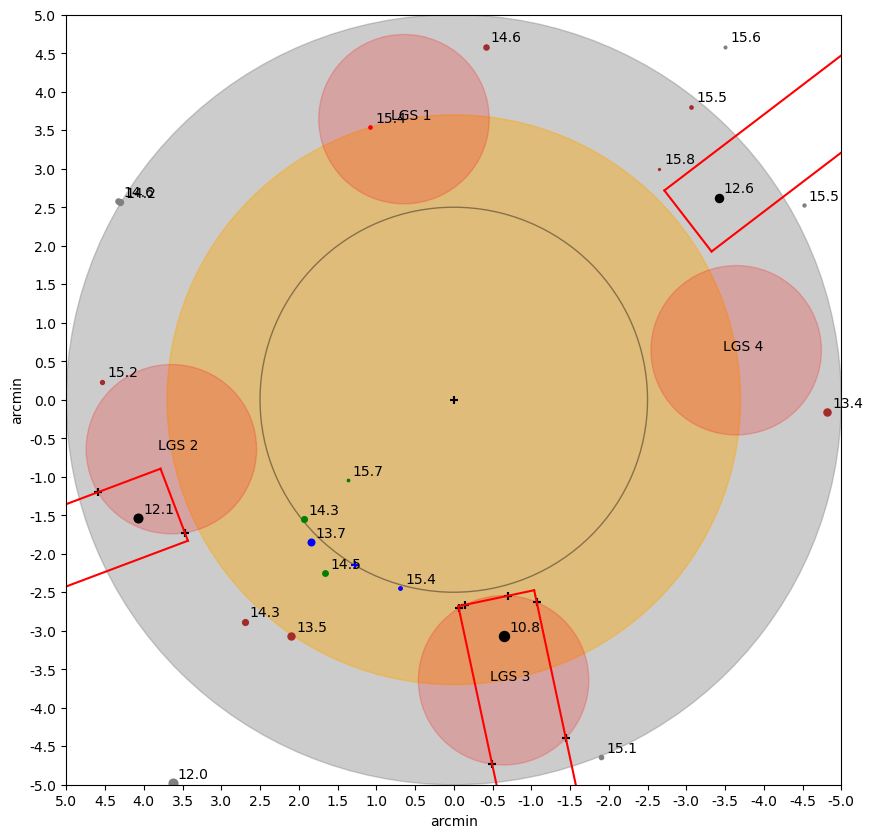

In [15]:
stars_data,input_data=GAIA_query(30,30,16)
a=FOV_stars(stars_data,input_data)
a.run()



INFO: Query finished. [astroquery.utils.tap.core]


In [25]:
stars_data,input_data=GAIA_query(30,30,18)
a=FOV_stars(stars_data,input_data)

INFO: Query finished. [astroquery.utils.tap.core]


0.02796834707260132
NGS Barycentre Radial Distance = 1.86 arcmin
NGS Area = -1.54 arcmin^2
PFS and LGS 3.0 overlap = 1.17 arcmin^2
PFS and LGS 2.0 overlap = 0.02 arcmin^2
PFS and LGS nan overlap = 0.00 arcmin^2


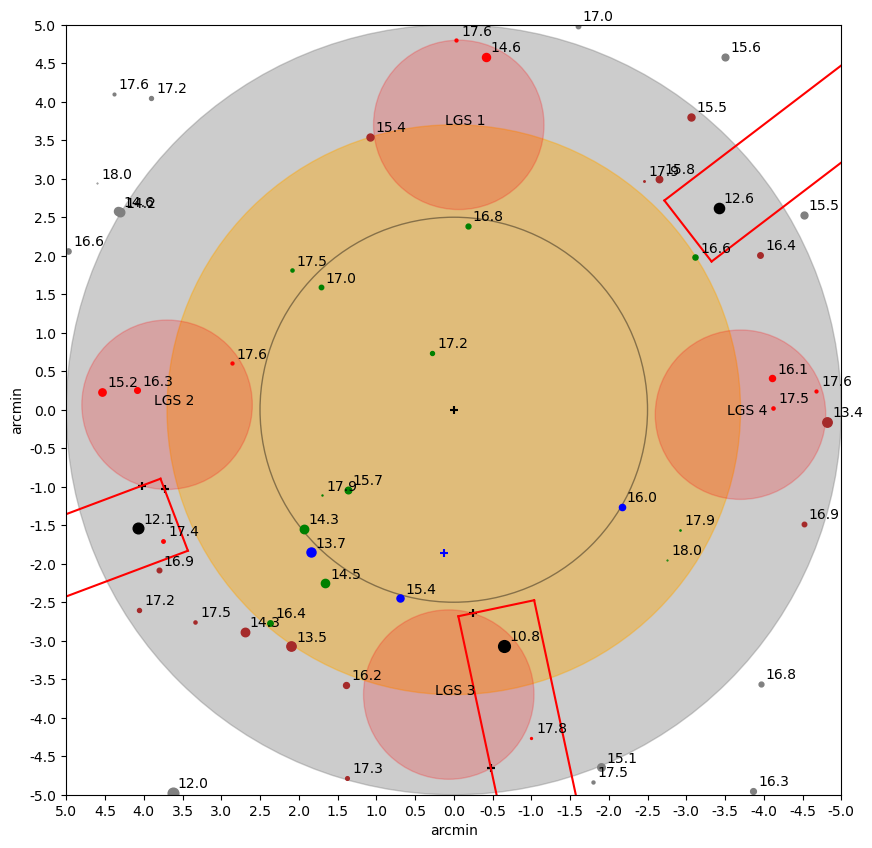

In [28]:
area_1=[]
area_2=[]
area_3=[]
start=time.time()
xrange=np.linspace(0,360,360)
for i in range(0,360):
    a.convert_stars_to_xy(a.input_data['ra0'],a.input_data['dec0'])
    a.find_stars_zones()
    a.find_PFS()
    a.find_LGS(np.radians(i))
    a.find_NGS()
    a.find_NGS_stats()
    area=a.find_PFS_overlap()
    area_1.append(area[0])
    area_2.append(area[1])
    area_3.append(area[2])
print((time.time()-start)/360)
a.plot()

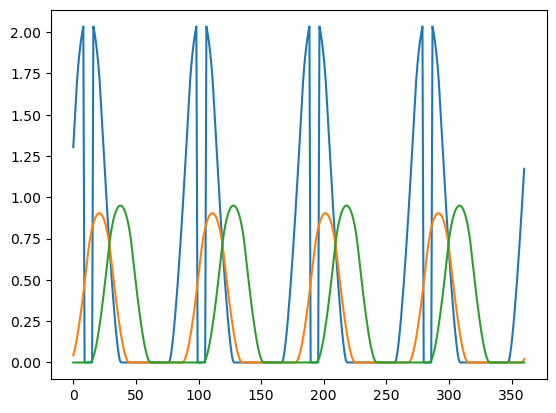

In [27]:
plt.plot(xrange,area_1)
plt.plot(xrange,area_2)
plt.plot(xrange,area_3)
